# Autoencoders

## Utils

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
np.random.seed(12345678) # for reproducibility

from keras import regularizers, losses, callbacks
from keras import backend as K
from math import sqrt

import tensorflow as tf

def KLregularizer(expected, coeff, tanh = True):
    """Kullback-Leibler regularizer for sparse autoencoder"""

    # tanh scaling to [0,1] interval
    if tanh:
        expected = (1 + expected) / 2
    
    def kl(x):
        """
        The Kullback-Leibler divergence for two Bernoulli distributions
        with mean `expected` and `x` respectively
        """

        # tanh scaling to [0,1] interval
        if tanh:
            x = (1 + x) / 2
        
        return tf.cond(
            # if x <= 0 or x == 1
            tf.logical_or(tf.less_equal(expected / x, 0), tf.less_equal((1 - expected)/(1 - x), 0)),
            # just return 0
            lambda: 0.,
            # else, compute KL divergence
            lambda: expected * K.log(expected / x) + (1 - expected) * K.log((1 - expected)/(1 - x))
        )

    def reg(observed_activations):
        """
        Calculates the regularization that needs to be applied to improve sparsity
        """
        
        # outputs of encoding layer will be shaped (batch_size, 32)
        # print(observed_activations.get_shape().as_list())
        observed = K.mean(observed_activations, axis = [0])
        # print("shape means: {}".format(observed.get_shape().as_list()))
        
        allkl = K.map_fn(kl, observed)
        sumkl = K.sum(allkl)

        return coeff * sumkl

    return reg

# following https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/
def contractive_loss(model, rec_err = losses.binary_crossentropy, tanh = True, lam = 2e-4):
    # derive either tanh or sigmoid
    der_act = (lambda h: 1 - h * h) if tanh else (lambda: h * (1 - h))
    
    def loss(y_pred, y_true):
        rec = rec_err(y_pred, y_true)

        W = K.variable(value=model.get_layer('encoded').get_weights()[0])  # N x N_hidden
        W = K.transpose(W)  # N_hidden x N
        h = model.get_layer('encoded').output
        dh = der_act(h)  # N_batch x N_hidden
        
        # N_batch x N_hidden * N_hidden x 1 = N_batch x 1
        contractive = lam * K.sum(dh**2 * K.sum(W**2, axis=1), axis=1)
        
        return rec + contractive

    return loss

def noise_input(x, proportion = 0.05):
    x_noisy = x + np.around(np.random.uniform(low = 0., high = 0.5 / (1 - proportion), size = x.shape))
    x_noisy = np.clip(x_noisy, 0., 1.)
    
    return x_noisy

def correntropy_loss(sigma = 0.2):
    def robust_kernel(alpha):
        return 1. / (sqrt(2 * np.pi) * sigma) * K.exp(- K.square(alpha) / (2 * sigma * sigma))

    def loss(y_pred, y_true):
        return -K.sum(robust_kernel(y_pred - y_true))

    return loss

class LossHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))


/home/ubuntu/miniconda3/envs/deeplearning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Autoencoder class

In [3]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers, losses, callbacks

# following https://blog.keras.io/building-autoencoders-in-keras.html
class Autoencoder():
    def __init__(self, input_dim = 784, encoding_dim = 36, weight_decay = True, sparse = False, contractive = False, denoising = False, robust = False, activation = "tanh"):
        self.weight_decay = weight_decay
        self.sparse = sparse
        self.contractive = contractive
        self.denoising = denoising
        self.robust = robust

        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.activation = activation

        attrs = []
        if self.sparse: attrs.append("sparse")
        if self.contractive: attrs.append("contractive")
        if self.denoising: attrs.append("denoising")
        if self.robust: attrs.append("robust")
        if not attrs: attrs.append("basic")
        if self.weight_decay: attrs.append("wd")

        self.name = "{}-{}-{}".format(
            "-".join(attrs),
            encoding_dim,
            activation
        )

        self.build()

    def build(self):
        # "encoded" is the encoded representation of the input
        activity_reg = KLregularizer(-0.7, 0.2) if self.sparse else regularizers.l1(0.)
        kernel_reg = regularizers.l2(0.02) if self.weight_decay else regularizers.l1(0.)
        
        # this is our input placeholder
        input_img = Input(shape=(self.input_dim,))
        
        encoded = Dense(self.encoding_dim, activation=self.activation
                        , activity_regularizer = activity_reg
                        , kernel_regularizer = kernel_reg
                        , name = "encoded")(input_img)

        # "decoded" is the lossy reconstruction of the input
        decoded = Dense(self.input_dim, activation=('linear' if self.activation == "linear" else 'sigmoid')
                        , name = "decoded")(encoded)

        # this model maps an input to its reconstruction
        self.model = Model(input_img, decoded)

        # this model maps an input to its encoded representation
        self.encoder = Model(input_img, encoded)

        # create a placeholder for an encoded (32-dimensional) input
        encoded_input = Input(shape=(self.encoding_dim,))
        # retrieve the last layer of the autoencoder model
        decoder_layer = self.model.layers[-1]
        # create the decoder model
        self.decoder = Model(encoded_input, decoder_layer(encoded_input))


# Mnist Training

In [4]:
import numpy as np
np.random.seed(12345678) # for reproducibility

# https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
import os
os.environ['PYTHONHASHSEED'] = '0'

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers, losses, callbacks
from keras import backend as K
from math import sqrt

import tensorflow as tf

from keras.datasets import mnist

class MNISTTrainer():
    def __init__(self, autoencoder = Autoencoder()):
        self.autoencoder = autoencoder
        (x_train, _), (x_test, self.y_test) = mnist.load_data()
        
        # normalize
        x_train = x_train.astype('float32') / 255.
        x_test = x_test.astype('float32') / 255.

        # flatten
        self.x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))

        self.x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
        if autoencoder.denoising:
            self.x_test_noisy = noise_input(self.x_test)

        self.name = ""

    def train(self, optimizer = "rmsprop", loss = losses.binary_crossentropy, epochs = 50):
        # Here, we use binary crossentropy as loss function
        # since the output of our model is in the interval [0,1]
        # and our data is normalized.
        # Otherwise we could use 'mean_squared_error'
        if self.autoencoder.robust:
            loss = correntropy_loss()
            
        if self.autoencoder.contractive:
            loss = contractive_loss(self.autoencoder.model, rec_err = loss)

        self.autoencoder.model.compile(optimizer = optimizer,
                                       loss = loss)

        # train
        history = LossHistory()
        if self.autoencoder.denoising:
            for ep in range(epochs):
                noisy_train = noise_input(self.x_train)
                self.autoencoder.model.fit(noisy_train, self.x_train,
                                           epochs = 1,
                                           batch_size = 256,
                                           shuffle = True,
                                           callbacks=[history],
                                           validation_data = (self.x_test, self.x_test))
        else:
            self.autoencoder.model.fit(self.x_train, self.x_train,
                                       epochs = epochs,
                                       batch_size = 256,
                                       shuffle = True,
                                       callbacks=[history],
                                       validation_data = (self.x_test, self.x_test))

        self.name = "{}-{}".format(
            optimizer,
            "mse" if loss == losses.mean_squared_error else ("xent" if loss == losses.binary_crossentropy or self.autoencoder.contractive else "corr")
        )

        with open("{}-{}.csv".format(self.autoencoder.name, self.name), "w") as out_file:
            out_file.write(",".join(("{}".format(x) for x in history.losses)))

        return self

    def predict_test(self):
        # encode and decode some digits
        # note that we take them from the *test* set
        encoded_imgs = self.autoencoder.encoder.predict(self.x_test)
        decoded_imgs = self.autoencoder.decoder.predict(encoded_imgs)

        if self.autoencoder.denoising:
            encoded_noisy = self.autoencoder.encoder.predict(self.x_test_noisy)
            decoded_noisy = self.autoencoder.decoder.predict(encoded_noisy)

        print("Mean activations: {}".format(encoded_imgs.mean()))
        
        # use Matplotlib (don't ask)
        import matplotlib.pyplot as plt

        def find_first_digit(d):
            return next(i for i in range(len(self.y_test)) if self.y_test[i] == d)

        indices = [find_first_digit(d) for d in range(10)]
        n = len(indices)  # how many digits we will display
        fig = plt.figure(figsize=(20, 4))

        rows = 3
        side = int(np.sqrt(self.autoencoder.encoding_dim))

        for i in range(n):
            
            if self.autoencoder.denoising:
                noisy_train = noise_input(self.x_train)
                ax = plt.subplot(rows, n, i + 1)
                plt.imshow(self.x_test_noisy[indices[i]].reshape(28, 28))
                plt.gray()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                
                # display encoding
                ax = plt.subplot(rows, n, i + 1 + n)
                plt.imshow(((encoded_noisy[indices[i]] + 1) / 2).reshape(side, side))
                plt.gray()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                
                ax = plt.subplot(rows, n, i + 1 + 2 * n)
                plt.imshow(decoded_noisy[indices[i]].reshape(28, 28))
                plt.gray()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
            else:
                # display original
                ax = plt.subplot(rows, n, i + 1)
                plt.imshow(self.x_test[indices[i]].reshape(28, 28))
                plt.gray()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
            
                # display encoding
                ax = plt.subplot(rows, n, i + 1 + n)
                plt.imshow(((encoded_imgs[indices[i]] + 1) / 2).reshape(side, side))
                plt.gray()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

                # display reconstruction
                ax = plt.subplot(rows, n, i + 1 + 2 * n)
                plt.imshow(decoded_imgs[indices[i]].reshape(28, 28))
                plt.gray()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

        plt.show()        
        fig.savefig("{}-{}.pdf".format(self.autoencoder.name, self.name), pad_inches = 0)

        return self

## Basic Autoencoder

In [5]:
encoding_dim = 36
ae = Autoencoder(encoding_dim=encoding_dim, weight_decay=False)


## Basic Autoencoder with Weight decay


In [6]:
wd = Autoencoder(encoding_dim=encoding_dim, weight_decay=True)

##  Sparse Autoencoder

In [7]:
sae = Autoencoder(
    encoding_dim=encoding_dim,
    weight_decay=False,
    sparse=True,
    contractive=False,
    denoising=False,
    robust=False)

In [8]:
cae = Autoencoder(
    encoding_dim=encoding_dim,
    weight_decay=False,
    sparse=True,
    contractive=False,
    denoising=True,
    robust=False)

In [9]:
dae = Autoencoder(
    encoding_dim=encoding_dim,
    weight_decay=False,
    sparse=True,
    contractive=False,
    denoising=True,
    robust=False)

In [10]:
rae = Autoencoder(
    encoding_dim=encoding_dim,
    weight_decay=True,
    sparse=False,
    contractive=False,
    denoising=False,
    robust=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/60
60000/60000 [==============================] - 2s 32us/step - loss: 0.3088 - val_loss: 0.2628
Epoch 2/60
60000/60000 [==============================] - 1s 19us/step - loss: 0.2626 - val_loss: 0.2604
Epoch 3/60
60000/60000 [==============================] - 1s 19us/step - loss: 0.2574 - val_loss: 0.2545
Epoch 4/60
60000/60000 [==============================] - 1s 20us/step - loss: 0.2528 - val_loss: 0.2509
Epoch 5/60
60000/60000 [==============================] - 1s 19us/step - loss: 0.2499 - val_loss: 0.2485
Epoch 6/60
60000/60000 [==============================] - 1s 19us/step - loss: 0.2479 - val_loss: 0.2467
Epoch 7/60
60000/60000 [==============================] - 1s 19us/step - loss: 0.2465 - val_loss: 0.2455
Epoch 8/60
60000/60000 [==============================] - 1s 20us/step - loss: 0.2455 - val_loss: 0.2447
Epoch 9/60
60000/60000 [==============================] - 1s 19us/step - loss: 0.2447 - val_loss: 0.2441
Epoch

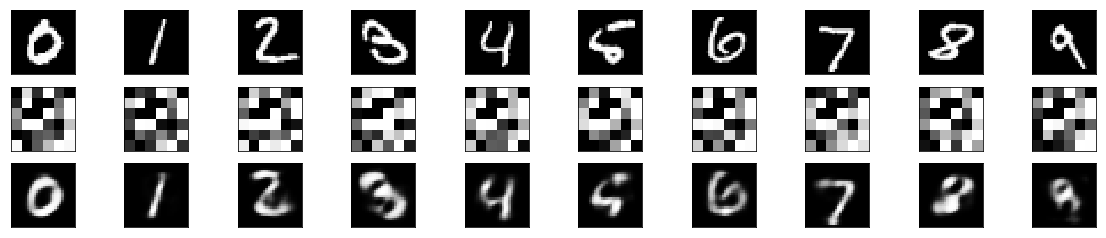

Train on 60000 samples, validate on 10000 samples
Epoch 1/60
60000/60000 [==============================] - 1s 22us/step - loss: 0.4479 - val_loss: 0.2697
Epoch 2/60
60000/60000 [==============================] - 1s 19us/step - loss: 0.2545 - val_loss: 0.2402
Epoch 3/60
60000/60000 [==============================] - 1s 19us/step - loss: 0.2300 - val_loss: 0.2220
Epoch 4/60
60000/60000 [==============================] - 1s 19us/step - loss: 0.2142 - val_loss: 0.2075
Epoch 5/60
60000/60000 [==============================] - 1s 19us/step - loss: 0.2036 - val_loss: 0.1979
Epoch 6/60
60000/60000 [==============================] - 1s 19us/step - loss: 0.1956 - val_loss: 0.1907
Epoch 7/60
60000/60000 [==============================] - 1s 19us/step - loss: 0.1891 - val_loss: 0.1833
Epoch 8/60
60000/60000 [==============================] - 1s 19us/step - loss: 0.1840 - val_loss: 0.1784
Epoch 9/60
60000/60000 [==============================] - 1s 19us/step - loss: 0.1796 - val_loss: 0.1757
Epoch

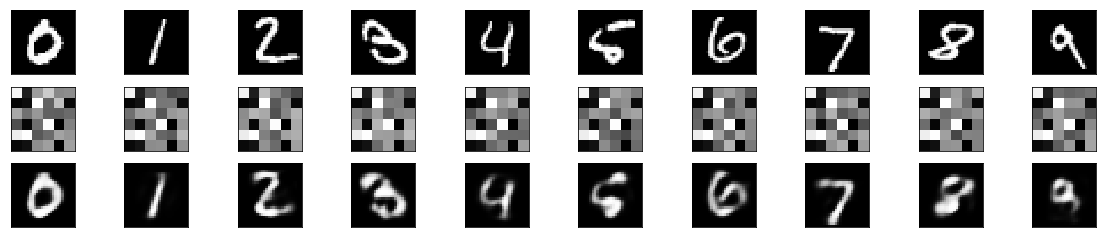

Train on 60000 samples, validate on 10000 samples
Epoch 1/60
60000/60000 [==============================] - 9s 156us/step - loss: 0.3564 - val_loss: 0.2727
Epoch 2/60
60000/60000 [==============================] - 9s 153us/step - loss: 0.2235 - val_loss: 0.2574
Epoch 3/60
60000/60000 [==============================] - 9s 153us/step - loss: 0.1981 - val_loss: 0.2422
Epoch 4/60
60000/60000 [==============================] - 9s 153us/step - loss: 0.1847 - val_loss: 0.2342
Epoch 5/60
60000/60000 [==============================] - 9s 153us/step - loss: 0.1759 - val_loss: 0.2215
Epoch 6/60
60000/60000 [==============================] - 9s 153us/step - loss: 0.1691 - val_loss: 0.2135
Epoch 7/60
60000/60000 [==============================] - 9s 153us/step - loss: 0.1639 - val_loss: 0.2063
Epoch 8/60
60000/60000 [==============================] - 9s 153us/step - loss: 0.1594 - val_loss: 0.1988
Epoch 9/60
60000/60000 [==============================] - 9s 153us/step - loss: 0.1557 - val_loss: 0.1

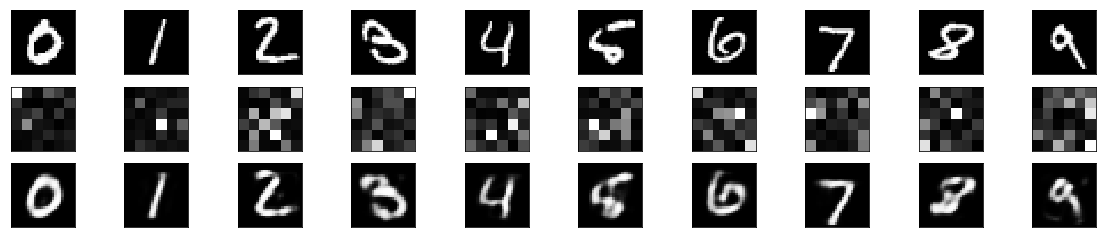

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 9s 156us/step - loss: 0.3476 - val_loss: 0.4391
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 9s 153us/step - loss: 0.2326 - val_loss: 0.4162
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 9s 153us/step - loss: 0.2048 - val_loss: 0.4682
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 9s 152us/step - loss: 0.1897 - val_loss: 0.5138
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 9s 152us/step - loss: 0.1803 - val_loss: 0.5592
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 9s 153us/step - loss: 0.1737 - val_loss: 0.5543
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/6000

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 9s 151us/step - loss: 0.1277 - val_loss: 0.3110
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 9s 151us/step - loss: 0.1275 - val_loss: 0.2956
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 9s 151us/step - loss: 0.1270 - val_loss: 0.3113
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 9s 151us/step - loss: 0.1272 - val_loss: 0.2893
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 9s 151us/step - loss: 0.1271 - val_loss: 0.2932
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 9s 151us/step - loss: 0.1267 - val_loss: 0.2917
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/6000

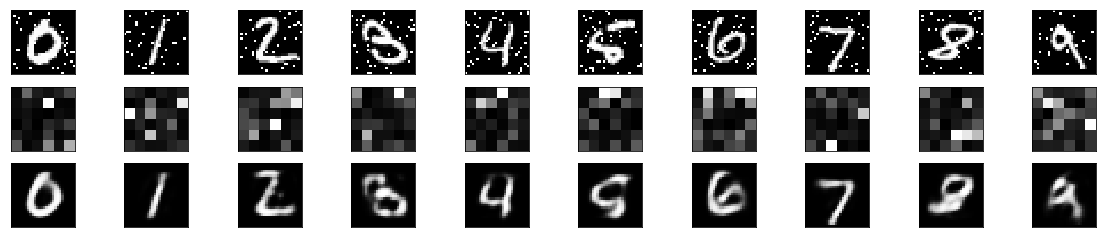

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 9s 155us/step - loss: 0.3515 - val_loss: 0.3903
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 9s 150us/step - loss: 0.2306 - val_loss: 0.4015
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 9s 151us/step - loss: 0.2040 - val_loss: 0.4434
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 9s 151us/step - loss: 0.1899 - val_loss: 0.4984
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 9s 151us/step - loss: 0.1801 - val_loss: 0.5499
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 9s 150us/step - loss: 0.1737 - val_loss: 0.5136
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/6000

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 9s 152us/step - loss: 0.1271 - val_loss: 0.3013
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 9s 151us/step - loss: 0.1268 - val_loss: 0.3046
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 9s 151us/step - loss: 0.1267 - val_loss: 0.2984
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 9s 152us/step - loss: 0.1264 - val_loss: 0.2892
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 9s 151us/step - loss: 0.1260 - val_loss: 0.2715
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 9s 151us/step - loss: 0.1261 - val_loss: 0.2852
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/6000

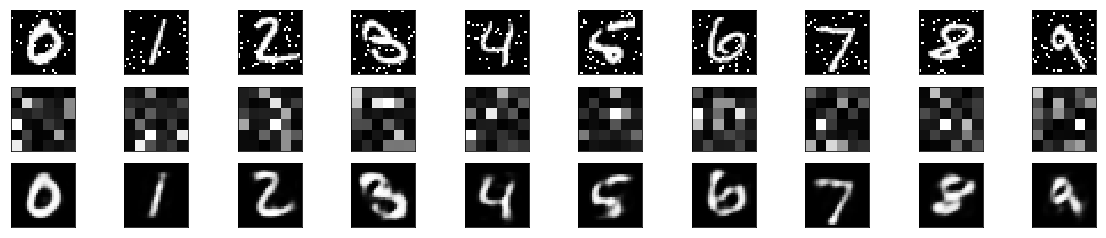

Train on 60000 samples, validate on 10000 samples
Epoch 1/60
60000/60000 [==============================] - 1s 18us/step - loss: -299954.0322 - val_loss: -331023.5073
Epoch 2/60
60000/60000 [==============================] - 1s 15us/step - loss: -331136.6870 - val_loss: -331266.5563
Epoch 3/60
60000/60000 [==============================] - 1s 15us/step - loss: -331462.0375 - val_loss: -331706.7572
Epoch 4/60
60000/60000 [==============================] - 1s 15us/step - loss: -332326.0400 - val_loss: -333324.5586
Epoch 5/60
60000/60000 [==============================] - 1s 15us/step - loss: -334353.3374 - val_loss: -335337.6761
Epoch 6/60
60000/60000 [==============================] - 1s 15us/step - loss: -336669.3358 - val_loss: -337740.7641
Epoch 7/60
60000/60000 [==============================] - 1s 15us/step - loss: -338727.1273 - val_loss: -339260.5339
Epoch 8/60
60000/60000 [==============================] - 1s 15us/step - loss: -339969.5021 - val_loss: -340413.1527
Epoch 9/60
600

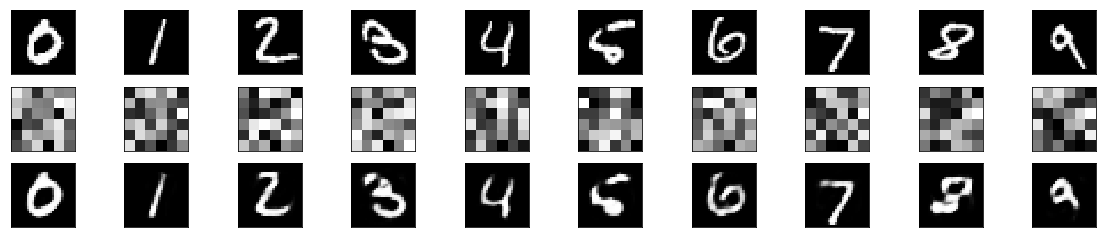

In [11]:
for typ in [ae, wd, sae, cae, dae, rae]:
    MNISTTrainer(typ).train(epochs=60, optimizer="rmsprop").predict_test()